First improvement from preliminary: Having an overall setting script, containing the various imports to run the scikit-allel analysis.

In [1]:
%run ../scripts/notebook_settings.py

Still using the same metadata as previous

In [6]:
meta_data_samples = pd.read_table("../data/meta_data_samples.txt", sep = " ")
meta_data_samples[:3]

,Unnamed: 0,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index
0,1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,0
1,2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,1
2,3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,2


Reading from the x_chr vcf

In [35]:
vcf_dir = "/faststorage/project/primatediversity/data/PG_baboons_pananu3_23_2_2021/"
vcf_names = "output.filtered.snps.{}.removed.AB.pass.vep.vcf.gz"
vcf_path = vcf_dir+vcf_names
vcf_callset = allel.read_vcf(vcf_path.format("chrX"), samples=meta_data_samples["PGDP_ID"].tolist())

The metadata file does not contain the correct indexes when loading all data, as the individuals Kasper removed are in the joint call.
To solve this temporarily, I only extract the IDs in the metadata.

In [36]:
#vcf_callset["samples"]
#meta_data_samples["PGDP_ID"].tolist()

Functions to run the PCA, first two from http://alimanfoo.github.io/2015/09/28/fast-pca.html 

In [37]:
def plot_ld(gn, title):
    m = allel.rogers_huff_r(gn) ** 2
    ax = allel.plot_pairwise_ld(m)
    ax.set_title(title)

def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

def offset_legend(fig):
    ax = fig.add_subplot(111)
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='best', bbox_to_anchor=(1,1))
    return lgd

def pruning_and_pca(vcf, IDs, subsampling_n, size, n_iter):
    print("Investigating {} individuals".format(len(IDs)))
    gt = allel.GenotypeArray(vcf["calldata/GT"])
    gt = gt.take(IDs, axis=1)
    ac = gt.count_alleles()[:] #Allele counts for each pos
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1) #Filtering for biallelic 
    #and at least two individuals in the alt state
    gf = gt.compress(flt, axis=0) #Applying filter
    gn = gf.to_n_alt() #Transform genotype to number of non-ref alleles
    if subsampling_n > len(gn):
        subsampling_n = len(gn)-1
    vidx = np.random.choice(gn.shape[0], subsampling_n, replace=False) #Random subsampling
    vidx.sort()
    gnr = gn.take(vidx, axis=0) #Applying the random subsample
    gnu = ld_prune(gnr, size=size, step=200, threshold=.1, n_iter=n_iter) #Pruning based on LD
    if len(gnu) > 150000:
        print("Too large dataset for pca")
        return "Too large dataset for pca"
    gnu = gnu[:] #Taking it out of chunked storage
    coords1, model1 = allel.pca(gnu, n_components=10, scaler='patterson') #Running the pca
    #The plotting solution in the example is inflexible, so I will try to make it through seaborn.
    pca_df = pd.DataFrame()
    c_transposed = coords1.transpose()
    for i in range(len(c_transposed)):
        pc = "pc{}".format(i+1)
        pca_df[pc] = c_transposed[i]
    pca_df_meta = pd.concat([pca_df, meta_data_samples.iloc[IDs].reset_index()], axis = 1, ignore_index=False)
    return pca_df_meta

Running the PCA. Inputs: The loaded vcf, the IDs to collect. 
The first int depicts number of sites to randomly sample.
The second depicts the window to calculate LD for.
The third depicts the number of times to LD_prune.

In [38]:
IDs = meta_data_samples.callset_index.values
pca_df = pruning_and_pca(vcf_callset, IDs, 3000000, 500, 2)

Investigating 160 individuals
iteration 1 retaining 187330 removing 1805307 variants
iteration 2 retaining 35463 removing 151867 variants


/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


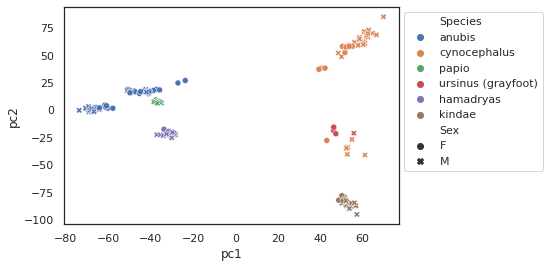

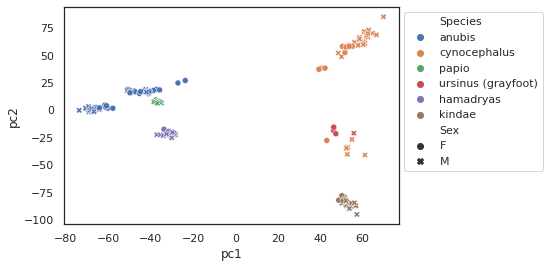

In [39]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="Species", style="Sex")
fig_males = scatter_sns.get_figure()
lgd = offset_legend(fig_males)
fig_males.savefig("../results/pca_x_with_males", bbox_extra_artists=[lgd], bbox_inches='tight')
fig_males

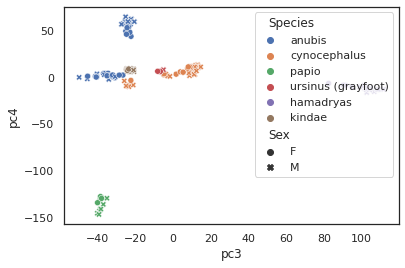

In [45]:
scatter_sns = sns.scatterplot(data = pca_df, x="pc3", y="pc4", hue="Species", style="Sex")

In [40]:
vcf_callset["samples"]

array(['PD_0199', 'PD_0200', 'PD_0201', 'PD_0202', 'PD_0203', 'PD_0204',
       'PD_0205', 'PD_0206', 'PD_0207', 'PD_0208', 'PD_0209', 'PD_0210',
       'PD_0211', 'PD_0212', 'PD_0213', 'PD_0214', 'PD_0215', 'PD_0216',
       'PD_0217', 'PD_0218', 'PD_0219', 'PD_0220', 'PD_0221', 'PD_0222',
       'PD_0223', 'PD_0224', 'PD_0225', 'PD_0226', 'PD_0227', 'PD_0228',
       'PD_0229', 'PD_0230', 'PD_0231', 'PD_0232', 'PD_0233', 'PD_0234',
       'PD_0235', 'PD_0236', 'PD_0237', 'PD_0238', 'PD_0239', 'PD_0240',
       'PD_0241', 'PD_0242', 'PD_0243', 'PD_0244', 'PD_0390', 'PD_0391',
       'PD_0392', 'PD_0393', 'PD_0394', 'PD_0395', 'PD_0396', 'PD_0397',
       'PD_0398', 'PD_0399', 'PD_0400', 'PD_0401', 'PD_0692', 'PD_0693',
       'PD_0694', 'PD_0695', 'PD_0696', 'PD_0697', 'PD_0698', 'PD_0699',
       'PD_0700', 'PD_0701', 'PD_0702', 'PD_0703', 'PD_0704', 'PD_0705',
       'PD_0706', 'PD_0707', 'PD_0708', 'PD_0709', 'PD_0710', 'PD_0711',
       'PD_0712', 'PD_0713', 'PD_0714', 'PD_0715', 